## Studying *Drosophila* egg-laying behavior using automated image analysis with Python (FlyScan-Course)

---
### Introduction

The goal of this course is to set up an automated procedure in Python to study the egg-laying behavior of *Drosophila*.  
In the working directory you will find the "*fly_images*" folder which contains all images that will be analysed during the course.  
The images show flies confined in a chamber with two egg-laying areas coated with different substrates (see picture below).   

**Our task will be to automatically track flies within the chamber and determine if they preferentially stay in one of the egg-laying areas.**

<img src="stock_files\fly_chamber_diagram.jpg" width=480 height=300 />

---
### 1) Manage paths

Here we will use [pathlib](https://docs.python.org/3/library/pathlib.html) library to simplify path management and avoid incompatibility between operating systems.  

**1.1)** Import `Path` module from `pathlib` library and check the path to the current directory using `Path.cwd()`:

In [1]:
from pathlib import Path
print(Path.cwd())

C:\Datas\3-GitHub_BDehapiot\Python_ImageProcessing_2022


This command should output the complete path to the downloaded directory.  
Otherwise, the notebook was probably started from the wrong directory   

**1.2)** Create a new path toward the "*fly_images*" folder contained in the downloaded directory: 

In [2]:
im_path = Path('fly_images')

Using this syntax, pathlib create a path object (or class) that can eventually be assigned to a variable (e.g. "*im_path*")  
You can retrieve the full path toward "*fly_images*" folder by using the `resolve()` method:

In [3]:
print(im_path) # relative path
print(im_path.resolve()) # full path
print(Path('fly_images').resolve()) # full path

fly_images
C:\Datas\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images
C:\Datas\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images


**1.3)** Use the `iterdir()` method to extract the paths of images contained in the "*fly_images*" folder: 

In [4]:
im_paths = [] # create an empty list
for path in Path('fly_images').iterdir():
    im_paths.append(path)

Print path info for the first image:

In [5]:
print(im_paths[0]) # relative path 
print(im_paths[0].resolve()) # full path

fly_images\21-01-06_Pi04_MidLight_000.tif
C:\Datas\3-GitHub_BDehapiot\Python_ImageProcessing_2022\fly_images\21-01-06_Pi04_MidLight_000.tif


Note that you can use attributes of the path object to retrieve informations about your image: 

In [6]:
print(im_paths[0].name) # name
print(im_paths[0].stem) # name without extension
print(im_paths[0].suffix) # extension only

21-01-06_Pi04_MidLight_000.tif
21-01-06_Pi04_MidLight_000
.tif


---
### 2) Import images 

**2.1)** Now that our image paths have been stored in "*im_paths*" , import the first image using the `io.imread` function from [skimage](https://scikit-image.org/) library:

In [7]:
from skimage import io
im_first = io.imread(im_paths[0])

This command import the first image as a numpy array, which is a handy format to manipulate images in Python.    
Check "im_first" type using the `type` function:

In [8]:
print(type(im_first))

<class 'numpy.ndarray'>


**2.2)** Determine height and width of "*im_first*" using the `shape` attribute:

In [9]:
print(im_first.shape) # 2 elements tuple
im_height = im_first.shape[0]
im_width = im_first.shape[1]

(480, 640)


**2.3)** Count the total number of images using the `len` function on "image_paths":  

In [10]:
im_count = len(im_paths)
print(im_count)

200


### <span style="color:SteelBlue"> Exercice 1

In this exercice you will import all images contained in "*fly_images*" folder as a 3D numpy array named "*im_all*".  
- Hint: create a zero array with the `np.zeros` function and fill it with imported images.

In [11]:
import numpy as np

In [12]:
# 1) create a zero array with shape (im_count, im_height, im_width)
# 2) fill this array with imported images

In [13]:
# correction
im_all = np.zeros([im_count, im_height, im_width], dtype='uint8')
for i, path in enumerate(im_paths):   
    im_all[i,...] = io.imread(path)  

You can visualize the 3D array as a time series in napari: 

In [14]:
import napari
viewer = napari.view_image(im_all)

---
### 3) Fly segmentation

In this section, we will design a series of operations to automatically segment flies from the static background.  
To do this, we will process images using the [numpy](https://numpy.org/doc/stable/user/index.html) and [skimage](https://scikit-image.org/) libraries and display the results using [matplotlib](https://matplotlib.org/stable/plot_types/index#).   
Here is an example to get started:

**3.1)** Compute the min and the max projection (over images) of "*im_all*" and display the results with matplotlib: 

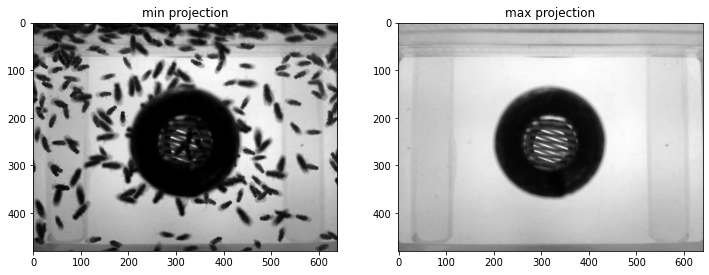

In [15]:
import matplotlib.pyplot as plt

# compute min and max projections
im_all_min = np.min(im_all, axis=0)
im_all_max = np.max(im_all, axis=0)

# display results with matplotlib
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
ax[0].imshow(im_all_min, cmap='gray')
ax[0].set_title('min projection')
ax[1].imshow(im_all_max, cmap='gray')
ax[1].set_title('max projection')
plt.show()


### <span style="color:SteelBlue"> Exercice 2

In this exercice you will compute the median projection of "*im_all*" and subtract it to "*im_all*" itself.  
You will then display the result for the first image using matplotlib.  
- Hint #1: use `np.median` and `np.subtract` functions.  
- Hint #2: do not modify the "*im_all*" variable as we will use it later.

In [16]:
# 1) compute median projection (im_all_median)
# 2) subtract median projection from raw images (im_all_sub)
# 3) display result for the first image in matplotlib

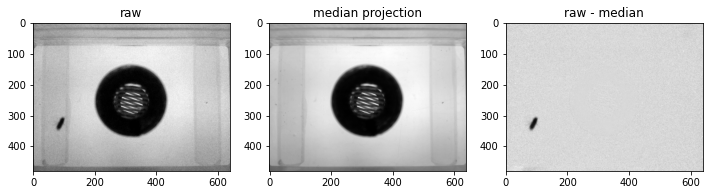

In [17]:
# Correction

# compute median projection
im_all_median = np.median(im_all, axis=0)

# subtract median projection from raw images
im_all_sub = np.subtract(im_all, im_all_median)

# display result for the first image in matplotlib
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
ax[0].imshow(im_all[0], cmap='gray')
ax[0].set_title('raw')
ax[1].imshow(im_all_median, cmap='gray')
ax[1].set_title('median projection')
ax[2].imshow(im_all_sub[0], cmap='gray')
ax[2].set_title('raw - median')
plt.show()

For convenience, invert "*im_all_sub*" to make fly pixels brighter than the backgorund. 

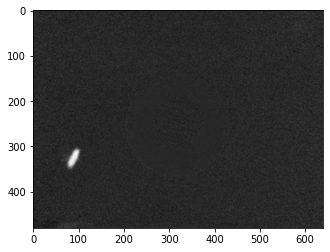

In [18]:
from skimage.util import invert

im_all_sub = invert(im_all_sub)
plt.imshow(im_all_sub[0], cmap='gray')
plt.show()

The next step will consists of separating pixels belonging to flies from those belonging to the background.  
Here, we will first apply a threshold, based on pixel intensity, to "*im_all_sub*". 

**3.2)** Determine a threshold value using the `threshold_yen` function and use it to create a binary mask:

19.89453125


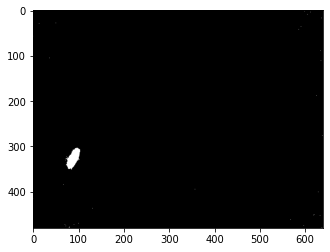

In [19]:
from skimage.filters import threshold_yen

thresh = threshold_yen(im_all_sub[0])
im_all_mask = im_all_sub > thresh
print(thresh)

plt.imshow(im_all_mask[0], cmap='gray')
plt.show()

Let's have a closer look:

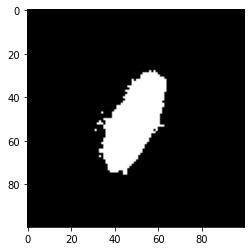

In [20]:
plt.imshow(im_all_mask[0,275:375,40:140], cmap='gray')
plt.show()

Although the result seems satisfying, a closer look reveals some rough edges and isolated pixels.  
Some more processing will be required to avoid such problems.

**3.3)** Apply a Gaussian blur on "*im_all_sub*" using the `gaussian` function before thresholding, then remove small binary objects with `remove_small_objects`. 

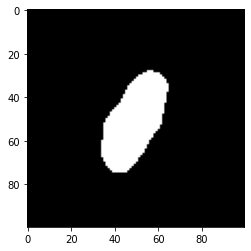

In [21]:
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects

im_all_mask = gaussian(im_all_sub, 2, channel_axis=0) > thresh
im_all_mask = remove_small_objects(im_all_mask, min_size=50)

plt.imshow(im_all_mask[0,275:375,40:140], cmap='gray')
plt.show()

Now that we are satisfy with our mask we can display the segmentation results in napari. 

**3.4)** Generate binary object outlines and overlay them to "*im_all_sub*":

In [22]:
from skimage.morphology import dilation

im_all_display = np.zeros_like(im_all)

for i, mask in enumerate(im_all_mask):    
    outlines = dilation(mask) ^ mask
    outlines = outlines.astype('uint8')*255 
    im_all_display[i,...] = np.maximum(im_all[i,...], outlines)

In [23]:
viewer = napari.view_image(im_all_display)

### <span style="color:SteelBlue"> Exercice 3

In this exercise, you will encapsulate all segmentation steps we have done so far into a single function.  

The function will take as arguments:  
- a time series we want to process ("*im_all*")
- a threshold coefficient to adjust the threshold retrieved using the yen method (see 3.2) 
- a sigma value to set the strength of the gaussian blur (see 3.3) 
- a minimum size in pixels to discard small binary objects (see 3.3) 

The function will output:  
- a mask as "*im_all_mask*"
- a display as "*im_all_display*" (see 3.4)

In [24]:
def im_segment(im_all, thresh_coeff=1.0, gaussian_sigma=2.0, min_size=50):
        
    # 1) subtract static background
    # 2) get binary mask
    # 3) make a display 
    
    ...
    
    return im_all_mask, im_all_display 

In [25]:
# Correction

def im_segment(im_all, thresh_coeff=1.0, gaussian_sigma=2.0, min_size=50):
    
    # subtract static background
    im_all_median = np.median(im_all, axis=0)
    im_all_sub = np.subtract(im_all, im_all_median)
    im_all_sub = invert(im_all_sub)

    # get binary mask
    im_all_mask = gaussian(im_all_sub, 2, channel_axis=0) > thresh*thresh_coeff
    im_all_mask = remove_small_objects(im_all_mask, min_size=50)
    
    # make a display
    for i, mask in enumerate(im_all_mask): 
        outlines = dilation(mask) ^ mask
        outlines = outlines.astype('uint8')*255 
        im_all_display[i,...] = np.maximum(im_all[i,...], outlines)
        
    return im_all_mask, im_all_display    

Once the function is defined, you can modify parameters and display the results with napari:

In [26]:
im_all_mask, im_all_display = im_segment(im_all, thresh_coeff=1.0, gaussian_sigma=2.0, min_size=50)
viewer = napari.view_image(im_all_display)

---
### 4) ???

In this section we will inspect individual binary objects to determine if segmented flies are located in egg-laying areas. 

**4.1)** Attribute a unique ID to "*im_all_mask*" binary objects using the `label` function:

In [ ]:
from skimage.morphology import label

im_all_labels = label(im_all_mask, connectivity=3)

You can inspect attributed ID by importing "*im_all_labels*" as a label layer in napari:

In [56]:
viewer = napari.view_labels(im_all_labels) # view_labels instead of view_image

**4.2)** Extract binary objects size using the `label` function:

In [ ]:
from skimage.measure import regionprops

im_all_props = []

for props in regionprops(im_all_labels):   
    
    temp_props = {
        'label': props['label'],
        'centroid': props['centroid'],
        'area': props['area'],       
        }
    
    im_all_props.append(temp_props)

for props in im_all_props:        
    print(props['centroid'])

(97.03222086256834, 106.24372529513782, 274.6392583919501)
(103.7903365091949, 216.53035944335122, 299.0478078061073)
(105.00580737612188, 267.65510219473566, 257.38140131231614)
(79.47688564476886, 334.04379562043795, 407.01216545012164)
